In [1]:
from collections import OrderedDict
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from model import UNet

if torch.cuda.is_available():
    print("Available GPUs:")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)} with {torch.cuda.get_device_properties(i).total_memory / (1024 ** 3)} GB")
else:
    print("No GPUs available.")


Available GPUs:
GPU 0: NVIDIA GeForce RTX 2080 Ti with 10.75341796875 GB
GPU 1: NVIDIA GeForce GTX 1050 Ti with 3.941162109375 GB


In [3]:
from collections import OrderedDict
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from torch.utils.data import DataLoader
from dataset import BrainSegmentationDataset
from transform import BinarizeMask, transforms

In [5]:
batch_size = 16

def datasets():
    aug_scale = 0.05
    aug_angle = 15
    image_size = 256

    images_dir = './dataset/kaggle_3m'

    train = None
    validation = BrainSegmentationDataset(
        images_dir=images_dir,
        subset="validation",
        image_size=image_size,
        random_sampling=False,
        transform=BinarizeMask()
    )

    return train, validation

def data_loaders():
    dataset_train, dataset_valid = datasets()

    def worker_init(worker_id):
        np.random.seed(42 + worker_id)

    loader_train = None
    loader_valid = DataLoader(
        dataset_valid,
        batch_size=batch_size,
        drop_last=False,
        num_workers=1,
        worker_init_fn=worker_init,
    )

    return loader_train, loader_valid

In [6]:
loader_train, loader_valid = data_loaders()
loaders = {
    "train": loader_valid,
    "valid": loader_valid,
}

reading validation images...
preprocessing validation volumes...
cropping validation volumes...
padding validation volumes...
resizing validation volumes...
normalizing validation volumes...
done creating validation dataset


In [8]:
epochs = 100
vis_freq = 10
vis_images = 200

device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

In [9]:
unet = UNet(in_channels=BrainSegmentationDataset.in_channels, out_channels=BrainSegmentationDataset.out_channels)
unet.to(device)

weights_path = "./weights/unet.pt"
state_dict = torch.load(weights_path, map_location=device)
unet.load_state_dict(state_dict)
unet.eval()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [11]:
from tqdm import tqdm
import numpy as np

In [12]:
from medpy.filter.binary import largest_connected_component
from utils import dsc, dsc_per_volume

In [14]:
input_list = []
pred_list = []
true_list = []

for i, data in tqdm(enumerate(loader_valid)):
    x, y_true = data
    x, y_true = x.to(device), y_true.to(device)

    y_pred = unet(x)
    y_pred_np = y_pred.detach().cpu().numpy()
    pred_list.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])

    y_true_np = y_true.detach().cpu().numpy()
    true_list.extend([y_true_np[s] for s in range(y_true_np.shape[0])])

    x_np = x.detach().cpu().numpy()
    input_list.extend([x_np[s] for s in range(x_np.shape[0])])

21it [00:01, 17.29it/s]


In [15]:
mean_dsc = np.mean(
    dsc_per_volume(
        pred_list,
        true_list,
        loader_valid.dataset.patient_slice_index,
    )
)

print(mean_dsc)

0.9350665195026039


In [16]:
def postprocess_per_volume(
    input_list, pred_list, true_list, patient_slice_index, patients
):
    volumes = {}
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        volume_in = np.array(input_list[index : index + num_slices[p]])
        volume_pred = np.round(
            np.array(pred_list[index : index + num_slices[p]])
        ).astype(int)
        volume_pred = largest_connected_component(volume_pred)
        volume_true = np.array(true_list[index : index + num_slices[p]])
        volumes[patients[p]] = (volume_in, volume_pred, volume_true)
        index += num_slices[p]
    return volumes

In [17]:
volumes = postprocess_per_volume(
    input_list,
    pred_list,
    true_list,
    loader_valid.dataset.patient_slice_index,
    loader_valid.dataset.patients,
)

In [18]:
import matplotlib.pyplot as plt
from utils import dsc, gray2rgb, outline

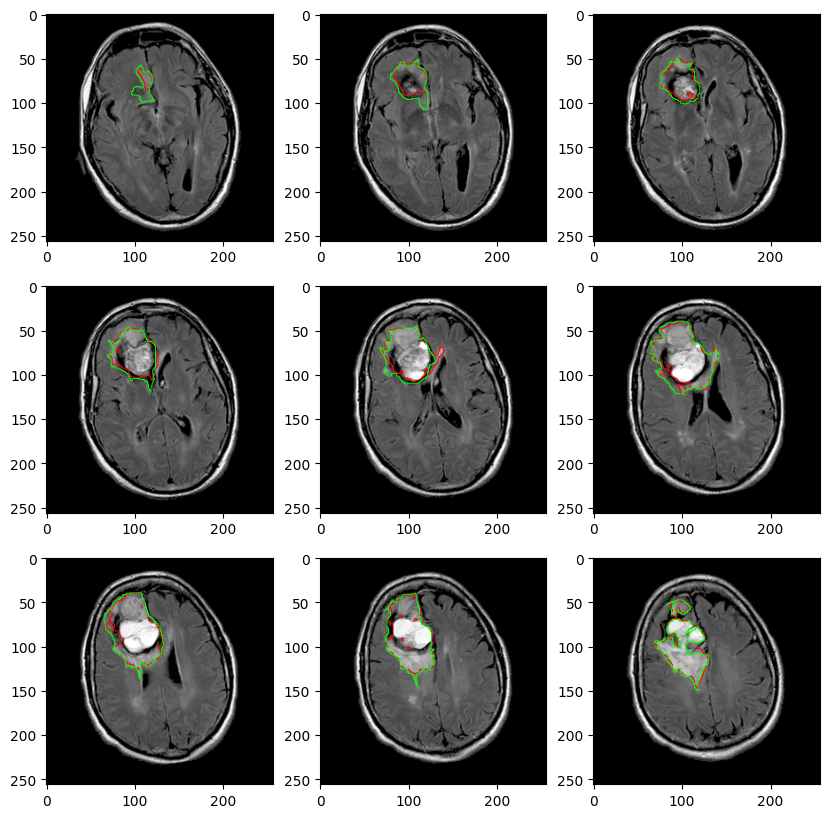

In [19]:
rows, cols = 3,3
fig = plt.figure(figsize=(10,10))
count = 0
for p in volumes:
    x = volumes[p][0]
    y_pred = volumes[p][1]
    y_true = volumes[p][2]
    for s in range(x.shape[0]):
        if s < 12:
            continue
        fig.add_subplot(rows, cols, count+1)
        
        image = gray2rgb(x[s, 1])  # channel 1 is for FLAIR  
        image = outline(image, y_pred[s, 0], color=[255, 0, 0])
        image = outline(image, y_true[s, 0], color=[0, 255, 0])
        
        plt.imshow(image)
        count += 1
        if count == rows*cols:
            break
    break

plt.show()